# Training a simple model on the MNIST dataset

In this notebook we are going to get familiar with using a deep learning library like Tensorflow to train a simple neural network. The network will be trained on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which contains small images of handwritten numerical digits. By the end of this training, the model should be able to accurately classify images with numerical digits.

Training a network on the MNIST dataset has become the 'hello world' of machine learning. 

This notebook is based on a notebook originally by [fchollet](https://twitter.com/fchollet) - the original creator of Keras.

### Installing TensorFlow / Keras

If you haven't installed TensorFlow and Keras, follow the instructions in [python setup instructions](https://github.com/colormotor/DMLAP/tree/main/python%20setup%20instructions).

### Importing TensorFlow / Keras

In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### Preparing the dataset

The code in the following cell:

- defines the number of classes for digits (0-9)

- defines the size of the input data (grayscale images 28x28 pixels)

- loads the MNIST dataset using the utils functions in Keras

- prepares the data for training. When training neural networks it is important the ensure that the size of the dataset is the same as the size of the input of the model, otherwise things will quickly break!

- converts class vectors to binary class matrices using the [utils functions in Keras](https://keras.io/api/utils/python_utils/#to_categorical-function)

**Things to try out:**

- Print the first item of x_train before and after you convert the array from uint8 (8-bit integers) to float32 (32-bit floats) 
- Print the first 10 items of y_train before and after you convert them to matrices

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
# Expand dimensions from (60000, 28, 28) to (60000, 28, 28, 1). 
# axis = -1 is adding one more axis to the array
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Building the model

This next section of code is where we build the neural network model, by defining the model in the class `Keras.Sequential` we are defining the *order* in which one layer connects to another, which is how we tell TensorFlow which part of the network connects to the next.

This network combines convolutional and pooling layers in the first several layers of the network (see clarifications below), with a dense layer in the end (Dense ~ the Keras term for fully connected). 

The output of the network is a vector of 10, the same as the number of classes we are classifying. Each one of these units represents a prediction of how likely the network predicts the input digit as being that class. We use the class with the highest confidence as the prediction from the model. 

**Helpful clarifications:**

- Convolutions are used as an extremely powerful tool for pattern recognition.

- Kernels are integers or tuples of 2 integers, specifying the height and width of the 2D convolution window, i.e. the window by which we examine a subset of the image.

- We can use different kernel sizes when we perform convolutions.

- The size of the kernel will determine how big the patterns are that we can detect with our convolution operation.

- A deep CNN has convolutional layers stacked on top of each other. Each layer is made up of lots of different feature extractors, responding to different kinds of patterns. The output(s) of one layer becomes the input(s) to the next one.

- Max-pooling is used to downsample the output information from one convolutional layer to the next one (by dividing the output matrix into windows and taking the maximum value in the window).

- Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector.

- The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

- Th softmax function is used to give us a probability distribution (probabilities that add up to 1) over classes for our input.

- 'None' in the output shapes means any batch size.

In [6]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

2023-02-12 23:14:06.792425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-12 23:14:06.792719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)        

### Training the model

This block of code is where we run the training of the model. It is only a few lines of code, because most of what happens in training is handled behind the scenes by TensorFlow. 

There are two parameters we need to define, the `batch_size` and the number of `epochs`. The batch size defines how many data samples we process at once during training, this helps speed up training if we use a bigger batch size (but is dependent on the size of the memory of our computer). Using a higher batch size generally leads to better results training, as the weights are updated based on the loss of the whole batch, which leads to more stable training than if we were to update the weights after each single example. Training in batches is a form of *regularisation* - something that will come up again and again with different tricks for getting the best performance out of training. 

The number of `epochs` defines how many iterations we perform over the dataset over training. The more epochs in training we perform, the longer training is going to take, but it often (but not always) leads to better performance.

In function call `model.compile` we define the loss function and the optimiser used to update the weights.

In function call `model.fit` we actually perform the training of the model.

**Things to try out:**

- Test the training with different parameters and see how these impact the accuracy of the model:

    - change the batch size and the number of epochs
    
    - search for different [loss functions](https://keras.io/api/losses/) and [optimizers](https://keras.io/api/optimizers/) from the Keras API reference

In [7]:
batch_size = 254
epochs = 10

# Here we are defining the loss function and the optimiser used for training.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Here we call the function that performs training, this will train for the number of epochs we have defined.
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10


2023-02-12 23:14:12.748578: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-12 23:14:12.938665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8484

2023-02-12 23:14:19.841130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 7s 22ms/step - loss: 0.5101 - accuracy: 0.8484 - val_loss: 0.1083 - val_accuracy: 0.9707
Epoch 2/10
213/213 [==============================] - 4s 20ms/step - loss: 0.1312 - accuracy: 0.9608 - val_loss: 0.0728 - val_accuracy: 0.9800
Epoch 3/10
213/213 [==============================] - 4s 21ms/step - loss: 0.0968 - accuracy: 0.9708 - val_loss: 0.0594 - val_accuracy: 0.9820
Epoch 4/10
213/213 [==============================] - 4s 21ms/step - loss: 0.0792 - accuracy: 0.9758 - val_loss: 0.0515 - val_accuracy: 0.9847
Epoch 5/10
213/213 [==============================] - 4s 20ms/step - loss: 0.0695 - accuracy: 0.9790 - val_loss: 0.0456 - val_accuracy: 0.9868
Epoch 6/10
213/213 [==============================] - 4s 20ms/step - loss: 0.0613 - accuracy: 0.9812 - val_loss: 0.0412 - val_accuracy: 0.9887
Epoch 7/10
213/213 [==============================] - 4s 20ms/step - loss: 0.0582 - accuracy: 0.9826 - val_loss: 0.0405 - val_accuracy: 0.9898
Epoch 8/10

### Evaluating the model

This next cell is where we evaluate the model. We take our trained model and test it against the test dataset. This will give us an overall accuracy score used to assess the model. 

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.031891755759716034
Test accuracy: 0.9893000721931458


### Testing the model with an actual input image

Here we load a test image to see if it classifies it correctly.

(28, 28, 1)


2023-02-12 23:15:48.822979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[6.3299842e-16 3.9232636e-12 8.3415674e-09 1.0000000e+00 1.9747203e-14
  2.3803277e-09 3.3745271e-14 2.9267585e-11 2.4616829e-09 2.3314051e-10]]


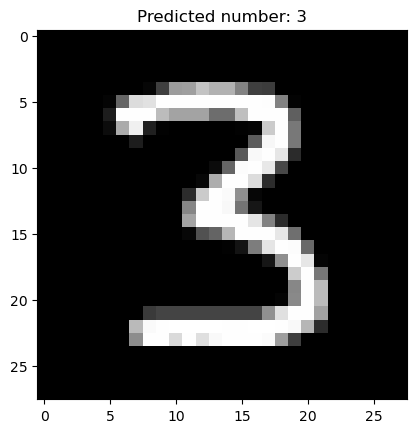

In [9]:
from tensorflow.keras.preprocessing import image
import canvas

img = image.load_img('./images/number3.png', target_size=(28, 28), color_mode='grayscale')
x = image.img_to_array(img)/255
print(x.shape)
x = np.expand_dims(x, 0)
predictions = model.predict(x, verbose=False)
print(predictions)
predicted = np.argmax(predictions)
canvas.show_image(img, title='Predicted number: ' + str(predicted), cmap='gray')

### Saving the model

This is where we save the trained model in the models folder to use it in the next notebook for more creative experimentations.

In [10]:
model.save('./models/basic_mnist.h5')